# Лабораторная работа №1

**Требования:**
* Python >= 3.X

Лабораторную работу необходимо выполнять в данном шаблоне. Результатом работы будет являться файл (с измененным именем), который необходимо выложить в Moodle.

**Важно!!!** Имя файлу задавайте по следующему шаблону **lab_1_Группа_ФамилияИО.ipynb**. Например: если Вас зовут Иванов Иван Иванович, и Вы обучаетесь в группе 6207_010302D, то имя файла будет выглядеть так **lab_1_6407_010302D_ИвановИИ.ipynb**.

In [83]:
# Код загрузки данных
# Если хотите добавить какие-либо библиотеки
# добавляйте их ИМЕННО ЗДЕСЬ
import nltk
from nltk.util import trigrams
import inflect
import re
import matplotlib.pyplot as plt
nltk.download('gutenberg', quiet=True)
nltk.download('punkt', quiet=True)

# Наименования книг
books = []
# Содержимое книг
raw_texts = []

for fileid in nltk.corpus.gutenberg.fileids():
    books.append(fileid)
    raw_texts.append(nltk.corpus.gutenberg.raw(fileid))

#### Шаг №1
Предобработайте тексты, которые содержатся в списке `raw_texts`, но сначала внимательно изучите их структуру. Сохраните полученные данные в списке `books_tokens` (в разрезе книг, как и было с сырыми текстами).

Порядок обработки текста:
* Замените все числа, которые представлены цифрами, их текстовым представлением (т.е. прописью). Пример: 1 = one, 23 = twenty three, 1042 = one thousand forty two, и т.п. См. библиотеку **inflect**.
* Приведите текст к нижнему регистру
* Произведите токинезацию, в качестве токенов выступают слова.

Подсказка: рекомендуется отлаживать алгоритмы на паре книг, рассчеты на всем корпусе идут продолжительное время.

In [90]:
# Создаем экземпляр для преобразования чисел в слова
p = inflect.engine()

def preprocess_text(raw_text):
    # Приводим весь текст к нижнему регистру один раз
    raw_text_lower = raw_text.lower()
    
    # Токенизация приведенного к нижнему регистру текста
    tokens = nltk.word_tokenize(raw_text_lower)
    
    # Финальный список обработанных токенов
    return [
        p.number_to_words(p.ordinal(token[:-2])) if re.match(r'^\d+(st|nd|rd|th)$', token) else
        p.number_to_words(token) if token.isdigit() else
        token
        for token in tokens
    ]

# Обработка всех текстов из raw_texts
processed_texts = [preprocess_text(raw_text) for raw_text in raw_texts]

#### Шаг №2

* Вычислите словари для каждой книги (переменная `books_vocabularies`).
* Вычислите словарь для всего корпуса (переменная `books_vocabulary`).
* Рассчитайте частоту употребления токенов в корпусе (переменная `freq_tokens`), и постройте график зависимости частоты употребления токена от токена (для 30-ти самых популярных).

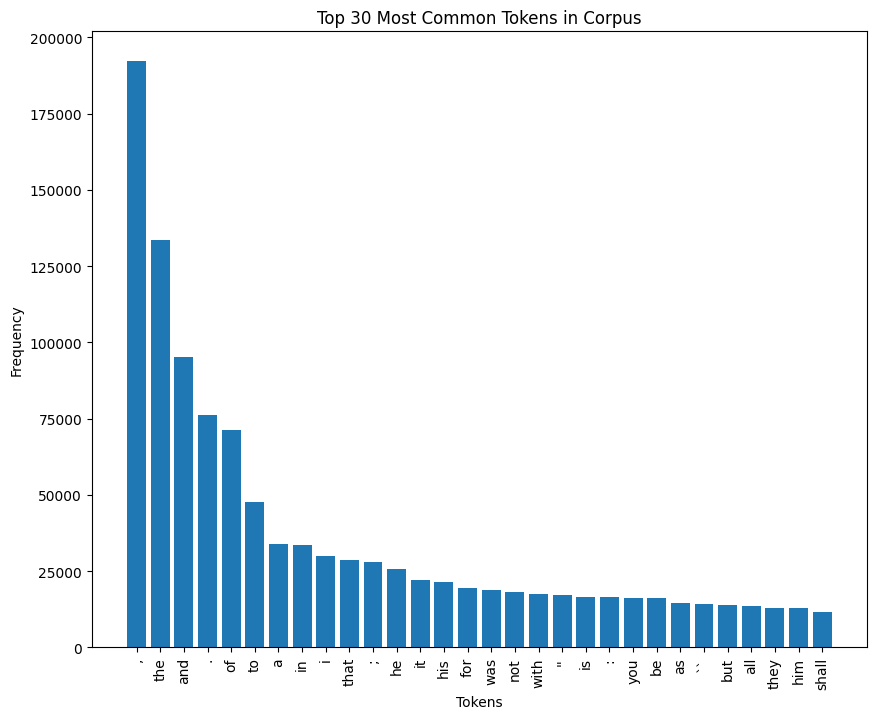

In [96]:
# Объединяем все токены по корпусу
all_tokens = [token for text in processed_texts for token in text]

# Вычисляем словари для каждой книги
books_vocabularies = list(map(set, processed_texts))

# Вычисляем словарь для всего корпуса, объединяя словари каждой книги
books_vocabulary = set().union(*books_vocabularies)

# Вычисляем частоту употребления токенов в корпусе
freq_tokens = nltk.FreqDist(all_tokens)

# Выводим 30 самых популярных токенов и их частоты
most_common_tokens = freq_tokens.most_common(30)

# Построение графика
tokens, frequencies = zip(*most_common_tokens)
plt.figure(figsize=(10, 8))
plt.bar(tokens, frequencies)
plt.xlabel('Tokens')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.title('Top 30 Most Common Tokens in Corpus')
plt.show()

#### Шаг №3
* Сгенерируйте список триграмм (переменная `trigrams`) по всему корпусу и рассчитайте частоту их употребления (переменная `freq_trigrams`).
* Реализуйте наивный генератор текста (30 токенов). 
    1. Для затравки берется два стартовых токена, которые становятся текущими. Первый токен выводится на экран.
    2. Второй токен из активной пары токенов выводится на экран. Если мы сгененрировали нужное количество текста, то останавливаем алгоритм.
    3. По текущей паре токенов (первые в триграмме) определяется наиболее употребительная траграмма, которая помечается как использованная. Использованные триграммы на последующих шагах в рассмотрении не участвуют. Второй и третий токены данной триграммы становятся текущими. Переходим к п. 2.

In [95]:
# Генерация списка триграмм по всему корпусу
all_trigrams = list(trigrams(all_tokens))

# Расчет частоты употребления триграмм
freq_trigrams = nltk.FreqDist(all_trigrams)

# Наивный генератор текста
def generate_text(start_tokens, num_tokens=30):
    current_tokens = start_tokens
    generated_text = [current_tokens[0]]  # Начинаем с первого стартового токена
    used_trigrams = set()  # Множество уже использованных триграмм

    for _ in range(num_tokens - 1):  # Уже добавили первый токен, генерируем остальные
        possible_trigrams = [trigram for trigram in freq_trigrams if trigram[:2] == tuple(current_tokens) and trigram not in used_trigrams]
        if not possible_trigrams:
            break  # Если нет подходящих триграмм, прерываем генерацию
        # Выбираем наиболее употребительную триграмму из возможных
        most_common_trigram = max(possible_trigrams, key=lambda trigram: freq_trigrams[trigram])
        used_trigrams.add(most_common_trigram)
        
        # Выводим второй токен текущих токенов (он будет новым для выхода)
        generated_text.append(current_tokens[1])
        
        # Обновляем текущие токены
        current_tokens = [current_tokens[1], most_common_trigram[2]]

    return ' '.join(generated_text)

# Затравка для генерации текста
start_tokens = ["the", "cat"]

# Генерация текста
generated_text = generate_text(start_tokens)
print(generated_text)

the cat , and the lord , and i will not be afraid of the lord . and he said , `` i am sure i do not know what
